In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

import random
import pickle

### 변수 저장

In [2]:
def storeVariable(data, variableName):
    with open(f'{variableName}.pickle', 'wb') as f:
        pickle.dump(data, f)

def loadVariable(fileName):
    with open(f'{fileName}', 'rb') as f:
        result = pickle.load(f)
    return result

# 데이터

In [3]:
def createDataset(dataset, window_size, shuffle = None):
    X = []
    y = []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:(i + window_size)])
        y.append(dataset[i + window_size][0])
    
    X = np.array(X)
    y = np.array(y)
    if (shuffle == True):
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
    
        return X_shuffled, y_shuffled
    
    else:
        return X, y

window_size = 60
numberOfFeatures = 2


# 데이터셋

### 원본(정상 + 비정상) 데이터

In [4]:
data = pd.read_csv('C:/Users/inhom/School/2024_1/2023연구재현/제일/101_1011_jeil.csv')
data.loc[:,'measure_dtm'] = pd.to_datetime(data.loc[:,'measure_dtm'])
data = data.replace("OFF", 0)
data = data.replace("ON", 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684582 entries, 0 to 684581
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   auto_collect_id    684582 non-null  object        
 1   measure_dtm        684582 non-null  datetime64[ns]
 2   attribute_1_value  684582 non-null  float64       
 3   attribute_2_value  684582 non-null  int64         
 4   attribute_3_value  684582 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 26.1+ MB


In [5]:
datasample = data.iloc[:, 2:4].values

min_data = np.min(datasample)
max_data = np.max(datasample - min_data)

datasample[:,0] = (datasample[:,0] - min_data) / max_data

Original_X, _ = createDataset(datasample, window_size, shuffle=False)

Original_X = Original_X.reshape(Original_X.shape[0], Original_X.shape[1], 2)

### 정상 데이터

In [6]:
GatheredPatterns = pd.read_csv('제일/chosenPatternJeil.csv')
GatheredPatterns.loc[:,'measure_dtm'] = pd.to_datetime(GatheredPatterns.loc[:,'measure_dtm'])
GatheredPatterns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29133 entries, 0 to 29132
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   auto_collect_id    29133 non-null  object 
 1   measure_dtm        29133 non-null  object 
 2   attribute_1_value  29133 non-null  float64
 3   attribute_2_value  29133 non-null  int64  
 4   attribute_3_value  29133 non-null  int64  
 5   Peak               29133 non-null  int64  
 6   StartPoint         29133 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.6+ MB


In [7]:
normalData = GatheredPatterns.copy()

temp_min = np.min(normalData.loc[:,'attribute_1_value'].values)
temp_max = np.max(normalData.loc[:,'attribute_1_value'].values - temp_min)

normalData.loc[:,'attribute_1_value'] = (normalData.loc[:,'attribute_1_value'] - temp_min) / temp_max

trainTestSplitLength = int(normalData.shape[0]*0.8)
trainValidSplitLength = int(trainTestSplitLength*0.75)

train = normalData.iloc[:trainValidSplitLength,2:4].values
valid = normalData.iloc[trainValidSplitLength : trainTestSplitLength, 2:4].values
test = normalData.iloc[trainTestSplitLength:,2:4].values

In [8]:
# window_size = 30

train_X, train_Y = createDataset(train, window_size, shuffle = True)
valid_X, valid_Y = createDataset(valid, window_size, shuffle = False)
test_X, test_Y = createDataset(test,window_size, shuffle = False)

In [9]:
numberOfFeatures = 2
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], numberOfFeatures)

### 문 열림 데이터

In [10]:
doorOpenedData = pd.read_csv('C:/Users/inhom/School/2024_1/2023연구재현/doorOpenedDataset.csv')

doorOpenedData.loc[:,'measure_dtm'] = pd.to_datetime(doorOpenedData.loc[:,'measure_dtm'])
doorOpenedData = doorOpenedData.replace("OFF", 0)
doorOpenedData = doorOpenedData.replace("ON", 1)

OpenedSample = doorOpenedData.iloc[:, 2:4].values

min_door = np.min(OpenedSample)
max_door = np.max(OpenedSample - min_data)
OpenedSample[:,0] = (OpenedSample[:,0] - min_door) / max_door

Opened_X, _ = createDataset(OpenedSample, window_size, shuffle = False)
Opened_X = Opened_X.reshape(Opened_X.shape[0], Opened_X.shape[1], 2)

# 모델

### LSTM

In [11]:
seed_value = 42
np.random.seed(seed_value)       
random.seed(seed_value)          
tf.random.set_seed(seed_value)

# def modelLSTM():
#     model = keras.Sequential()

#     model.add(keras.layers.LSTM(64, input_shape = (train_X.shape[1], numberOfFeatures), activation = 'relu', return_sequences = True)) 
#     model.add(keras.layers.Dropout(0.3))

#     model.add(keras.layers.LSTM(32, return_sequences = True)) 
#     model.add(keras.layers.Dropout(0.3))

#     model.add(keras.layers.LSTM(16, return_sequences = False))
#     model.add(keras.layers.Dropout(0.3))

#     model.add(keras.layers.Dense(8))
#     model.add(keras.layers.Dropout(0.3))

#     model.add(keras.layers.Dense(1))

#     return model

# def modelLSTM():
#     model = keras.Sequential()

#     model.add(keras.layers.LSTM(32, input_shape = (train_X.shape[1], numberOfFeatures), activation = 'relu', return_sequences = True)) 
#     model.add(keras.layers.Dropout(0.3))

#     model.add(keras.layers.LSTM(16)) 
#     model.add(keras.layers.Dropout(0.3))

#     model.add(keras.layers.Dense(8, activation = 'relu'))
#     model.add(keras.layers.Dropout(0.3))

#     model.add(keras.layers.Dense(1, activation = 'sigmoid'))

#     return model

# modelLSTM = modelLSTM()

def modelLSTM():
    model = keras.Sequential()

    model.add(keras.layers.LSTM(64, input_shape = (train_X.shape[1], numberOfFeatures), activation = 'relu', return_sequences = True)) 
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.LSTM(32, return_sequences = False)) 
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(16))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(8))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(1))

    return model

modelLSTM = modelLSTM()

modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            17152     
                                                                 
 batch_normalization (BatchN  (None, 60, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)                0

In [12]:
modelLSTM.compile(optimizer='adam', loss='mse', metrics=['MSE'])
earlyStopping = EarlyStopping( monitor='val_loss', patience=30, verbose=1, restore_best_weights = True)
history = modelLSTM.fit(train_X, train_Y, epochs=500, batch_size=32, validation_data=(valid_X, valid_Y), callbacks=[earlyStopping])

Epoch 1/500
545/545 [==============================] - 32s 53ms/step - loss: 0.2487 - MSE: 0.2487 - val_loss: 0.0077 - val_MSE: 0.0077
Epoch 2/500
545/545 [==============================] - 27s 49ms/step - loss: 0.0508 - MSE: 0.0508 - val_loss: 0.0038 - val_MSE: 0.0038
Epoch 3/500
545/545 [==============================] - 27s 50ms/step - loss: 0.0185 - MSE: 0.0185 - val_loss: 0.0025 - val_MSE: 0.0025
Epoch 4/500
545/545 [==============================] - 27s 49ms/step - loss: 0.0111 - MSE: 0.0111 - val_loss: 0.0013 - val_MSE: 0.0013
Epoch 5/500
545/545 [==============================] - 27s 49ms/step - loss: 0.0086 - MSE: 0.0086 - val_loss: 0.0013 - val_MSE: 0.0013
Epoch 6/500
545/545 [==============================] - 27s 50ms/step - loss: 0.0079 - MSE: 0.0079 - val_loss: 0.0016 - val_MSE: 0.0016
Epoch 7/500
545/545 [==============================] - 27s 50ms/step - loss: 0.0072 - MSE: 0.0072 - val_loss: 0.0020 - val_MSE: 0.0020
Epoch 8/500
545/545 [==============================] - 

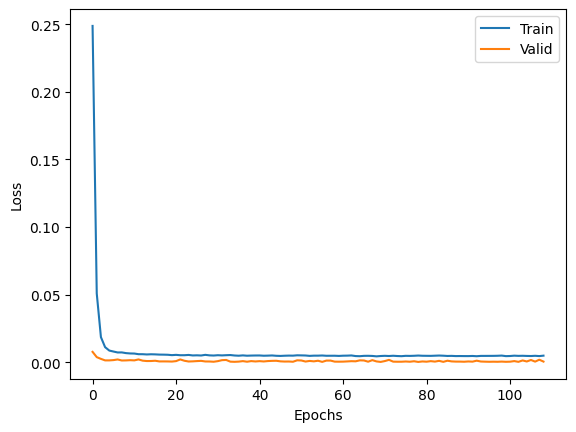

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [14]:
modelLSTM.evaluate(test_X, test_Y)

181/181 [==============================] - 2s 12ms/step - loss: 4.2262e-04 - MSE: 4.2262e-04


[0.0004226245218887925, 0.0004226245218887925]

In [15]:
modelLSTM.save('modelLSTMver17(SHUFFLED).h5')

In [16]:
TrainedmodelLSTM = keras.models.load_model('modelLSTMver17(SHUFFLED).h5')

#### prediction(LSTM)

In [17]:
def predict(model, data, idx, batch_size = 256):
    num_samples = min(idx, len(data))
    result = []
    batch_indices = np.arange(0, num_samples, batch_size)
    for start_idx in batch_indices:
        end_idx = min(start_idx + batch_size, num_samples)
        batch_data = np.array([data[i].reshape(1, data[i].shape[0], numberOfFeatures) for i in range(start_idx, end_idx)])
        batch_data = np.vstack(batch_data) 
        batch_predictions = model.predict(batch_data)
        result.extend(batch_predictions.flatten())

    result = np.array(result).reshape(-1, 1)

    nan_array = np.full((window_size, 1), np.nan) 
    result = np.concatenate((nan_array, result), axis=0)

    return result

In [18]:
train_X_scale_restored = train_X.copy()
train_X_scale_restored[:,0,0] = train_X[:,0,0] * (temp_max - temp_min) + temp_min

train_X_predict = predict(TrainedmodelLSTM, train_X_scale_restored, train_X.shape[0])

train_X_predict_restored = train_X_predict * (temp_max - temp_min) + temp_min

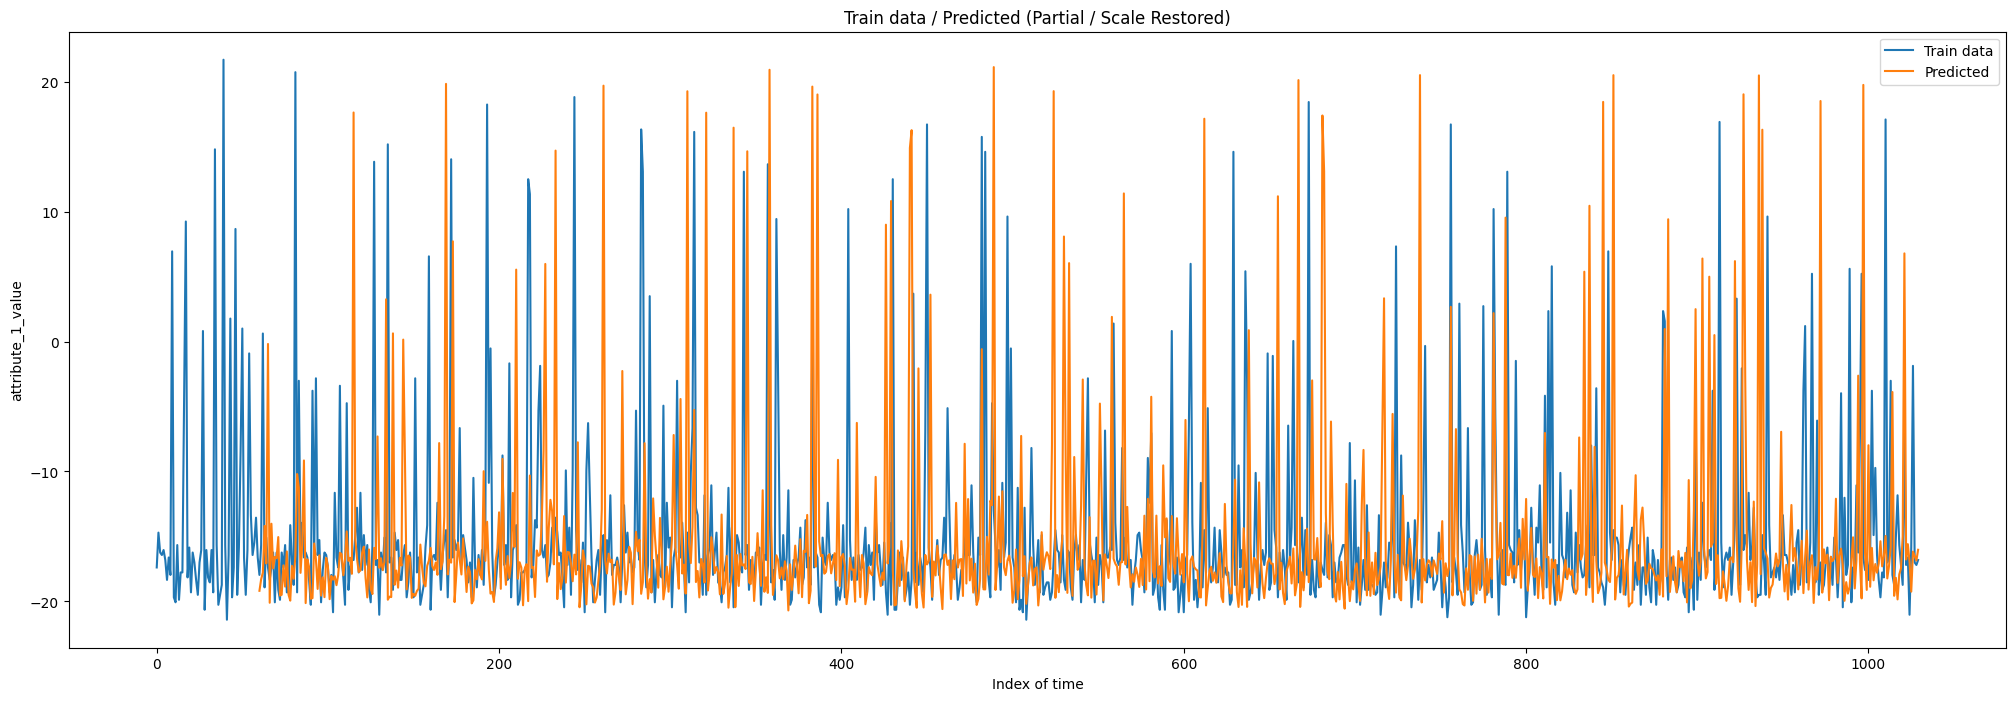

In [19]:
%matplotlib inline
whereToSlice = 1030
plt.figure(figsize = (25,8))
plt.plot(np.arange(whereToSlice), train_X_scale_restored[:whereToSlice,0,0])
plt.plot(np.arange(whereToSlice), train_X_predict_restored[:whereToSlice])
plt.title('Train data / Predicted (Partial / Scale Restored)')
plt.xlabel('Index of time')
plt.ylabel('attribute_1_value')
plt.legend(['Train data', 'Predicted'])
plt.show()

In [20]:
Original_X_scale_restored = Original_X.copy()
Original_X_scale_restored[:,0,0] = Original_X[:,0,0] * (max_data - min_data) + min_data

original_predict = predict(TrainedmodelLSTM, Original_X_scale_restored, Original_X.shape[0])

original_predict_scale_restored = original_predict * (max_data - min_data) + min_data

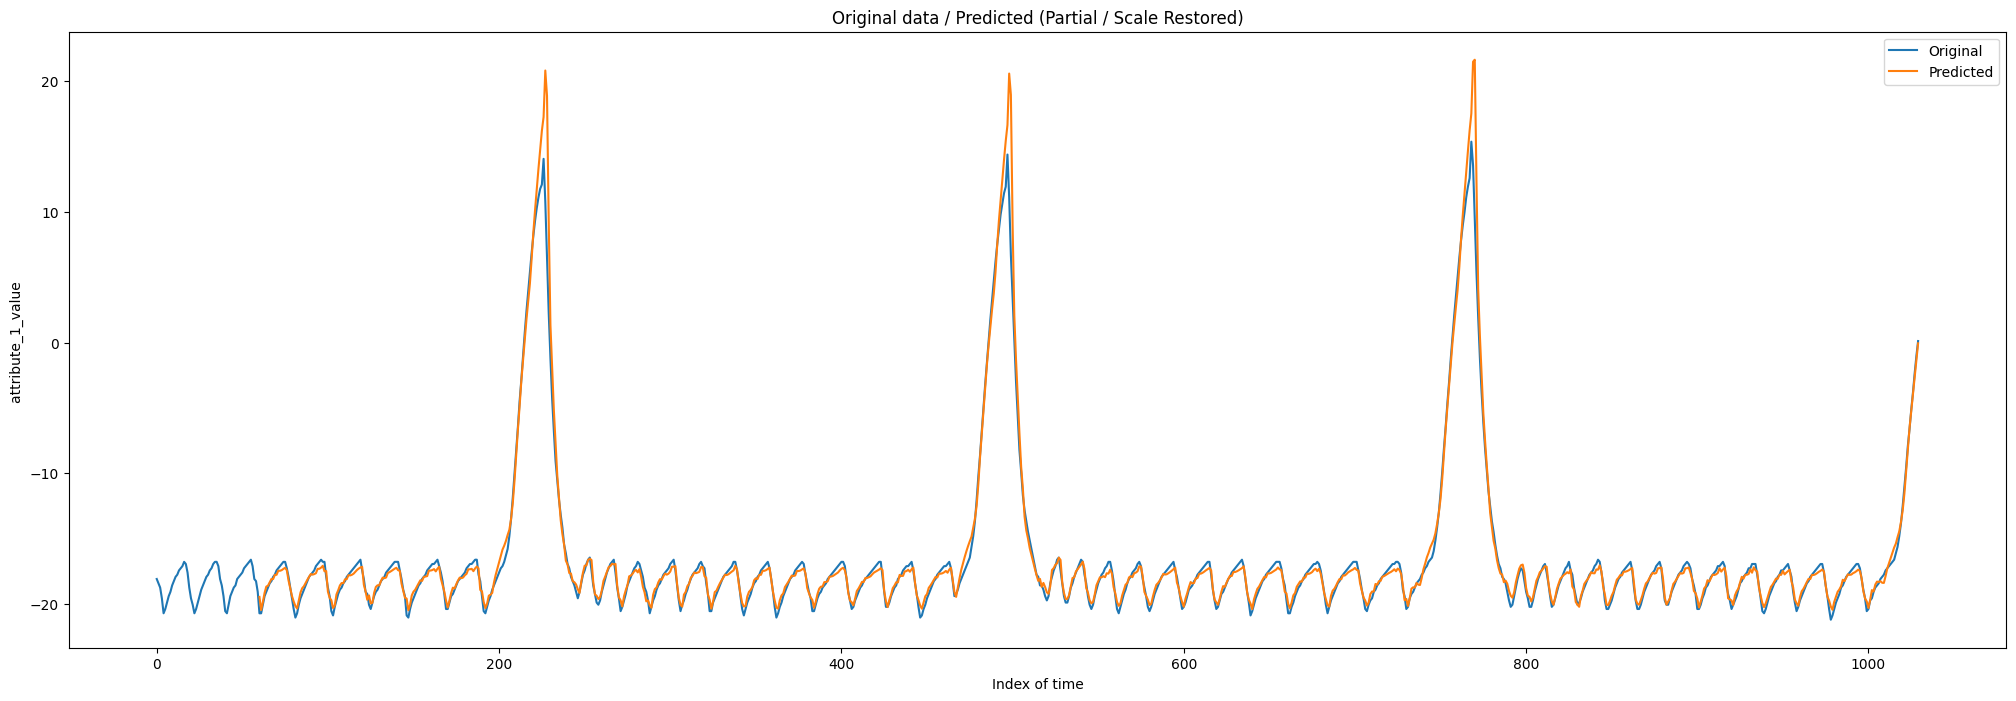

In [21]:
whereToSlice = 1030
plt.figure(figsize = (25,8))
plt.plot(np.arange(whereToSlice), Original_X_scale_restored[:whereToSlice,0,0])
plt.plot(np.arange(whereToSlice), original_predict_scale_restored[:whereToSlice])
plt.title('Original data / Predicted (Partial / Scale Restored)')
plt.xlabel('Index of time')
plt.ylabel('attribute_1_value ')
plt.legend(['Original', 'Predicted'])
plt.show()

In [22]:
test_X_scale_restored = test_X.copy()
test_X_scale_restored[:,0,0] = test_X[:,0,0] * (temp_max - temp_min) + temp_min

test_X_predict = predict(TrainedmodelLSTM, test_X, test_X.shape[0])

test_X_predict_scale_restored = test_X_predict * (temp_max - temp_min) + temp_min

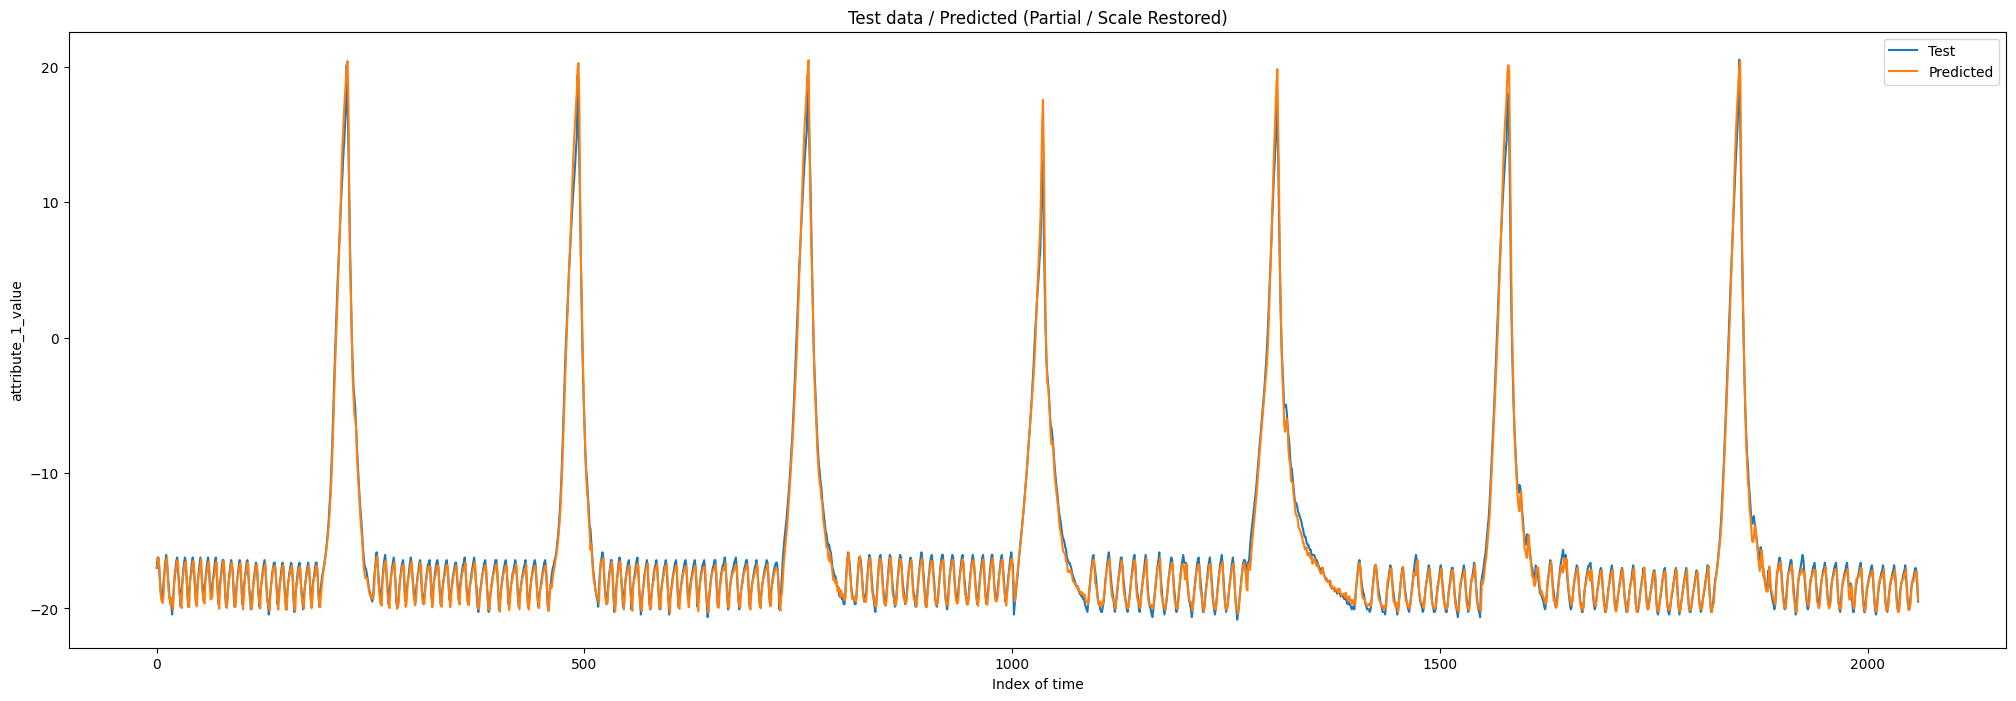

In [23]:
%matplotlib inline
whereToStart = 1030
whereToEnd = 3090
plt.figure(figsize = (25,8))
plt.plot(np.arange(whereToEnd - whereToStart), test_X_scale_restored[whereToStart:whereToEnd,0,0])
plt.plot(np.arange(whereToEnd - whereToStart), test_X_predict_scale_restored[whereToStart:whereToEnd])
plt.title('Test data / Predicted (Partial / Scale Restored)')
plt.xlabel('Index of time')
plt.ylabel('attribute_1_value')
plt.legend(['Test', 'Predicted'])
plt.show()

In [111]:
# storeVariable(train_X_predict_restored, 'train_X_predict_restored')
# storeVariable(test_X_predict_scale_restored, 'test_X_predict_scale_restored')
# storeVariable(original_predict_scale_restored, 'original_predict_scale_restored')

### Improved_LSTM

In [10]:
def improved_modelLSTM():
    model = Sequential()

    model.add(LSTM(32, input_shape=(train_X.shape[1], numberOfFeatures), activation='relu', return_sequences=True))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.Dropout(0.2))

    model.add(LSTM(16, return_sequences=False))  
    model.add(keras.layers.BatchNormalization())  
    model.add(keras.layers.Dropout(0.2))

    model.add(Dense(8, activation='relu'))
    model.add(keras.layers.Dropout(0.2))

    model.add(Dense(1, activation='linear')) 

    return model

In [11]:
modelLSTM = improved_modelLSTM()
modelLSTM.compile(optimizer = keras.optimizers.RMSprop(), loss='mse', metrics=['mse'])

Epoch 1/200
891/891 [==============================] - 33s 34ms/step - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0103 - val_mse: 0.0103 - lr: 0.0010
Epoch 2/200
891/891 [==============================] - 30s 33ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0029 - val_mse: 0.0029 - lr: 0.0010
Epoch 3/200
891/891 [==============================] - 30s 34ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0026 - val_mse: 0.0026 - lr: 0.0010
Epoch 4/200
891/891 [==============================] - 30s 33ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0034 - val_mse: 0.0034 - lr: 0.0010
Epoch 5/200
891/891 [==============================] - 30s 33ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0019 - val_mse: 0.0019 - lr: 0.0010
Epoch 6/200
891/891 [==============================] - 30s 33ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0011 - val_mse: 0.0011 - lr: 0.0010
Epoch 7/200
891/891 [==============================] - 30s 34ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.

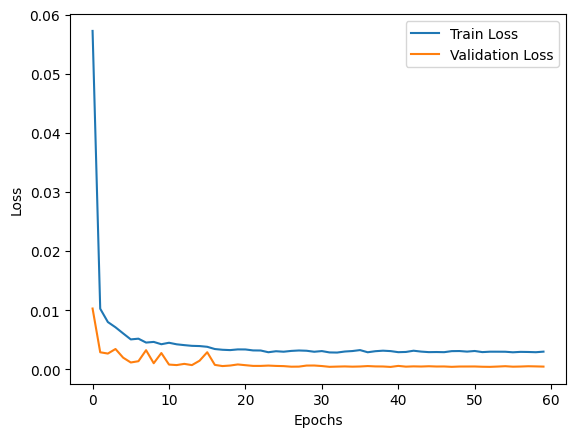

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=1e-4, min_lr=1e-5)
history = modelLSTM.fit(train_X, train_Y, epochs=200, batch_size=16, validation_data=(valid_X, valid_Y), callbacks=[early_stopping, reduce_lr])

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
TrainedmodelLSTM = keras.models.load_model('ImprovedLSTMver1.h5')

### LSTM(Error / visiualize)

In [24]:
# LSTM 오류(모음)
def calculateError(data, predicted) -> list:
    # MAEresult = np.abs(data[:,0] - predicted)
    MAEresult = np.abs(data[:,0,0] - predicted)
    # MSEresult = np.square(data[:,0] - predicted)
    MSEresult = np.square(data[:,0,0] - predicted)
    return MAEresult, MSEresult

In [25]:
OriginalMAE, OriginalMSE = calculateError(Original_X_scale_restored, original_predict_scale_restored.reshape(1,-1)[0,:-window_size])
# TestMAE, TestMSE = calculateError(test_X_scale_restored, test_X_predict_scale_restored.reshape(1,-1)[0,:-window_size])

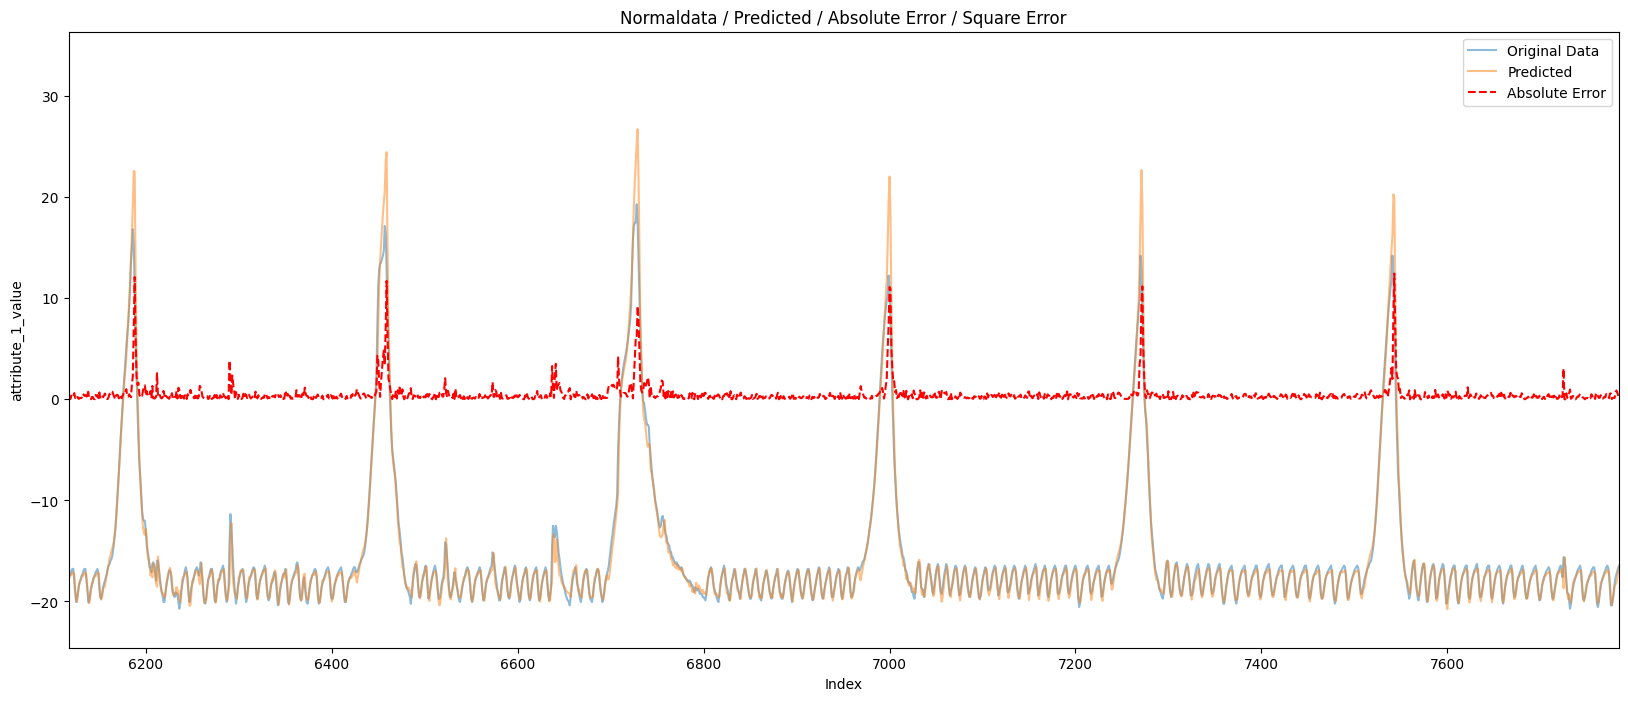

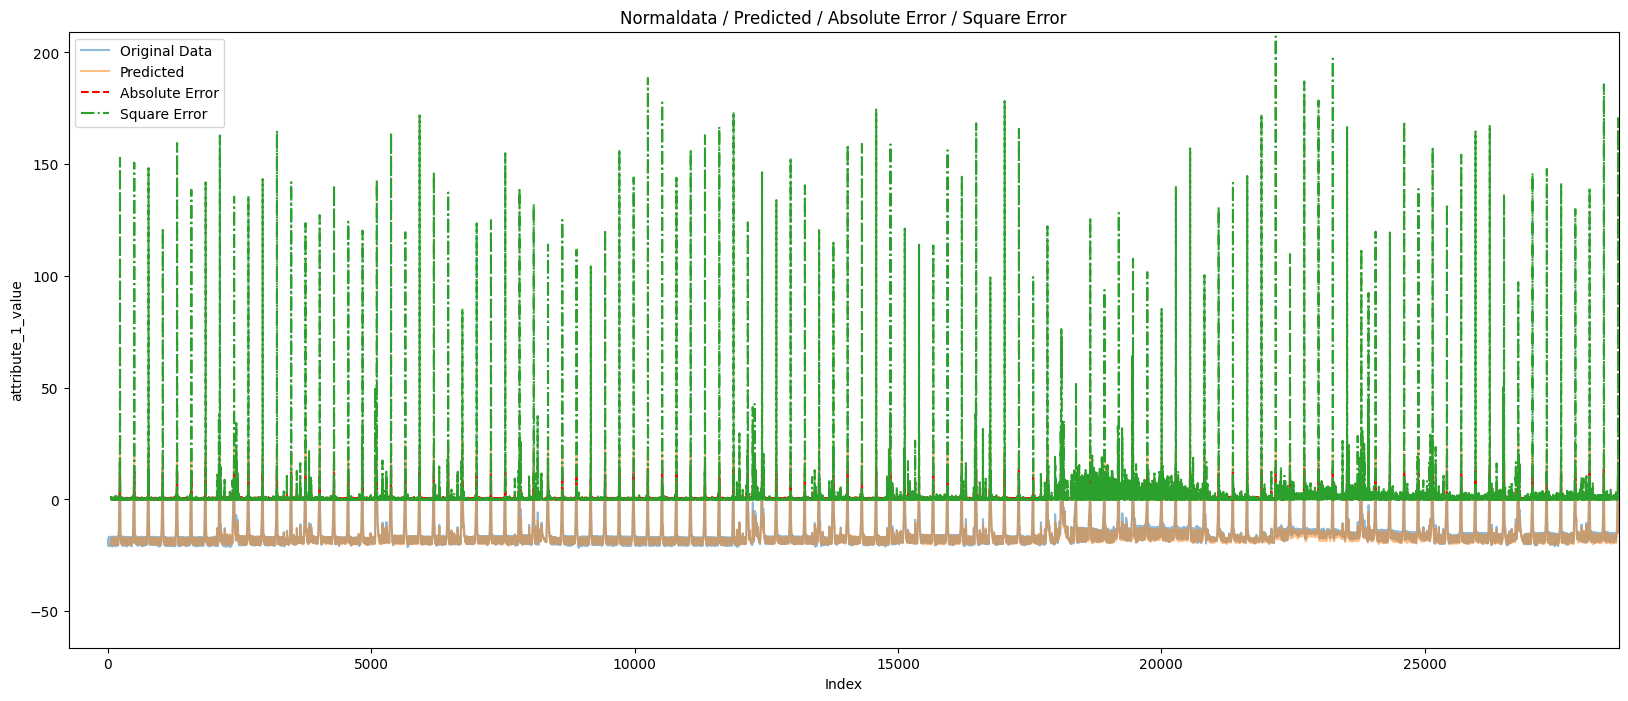

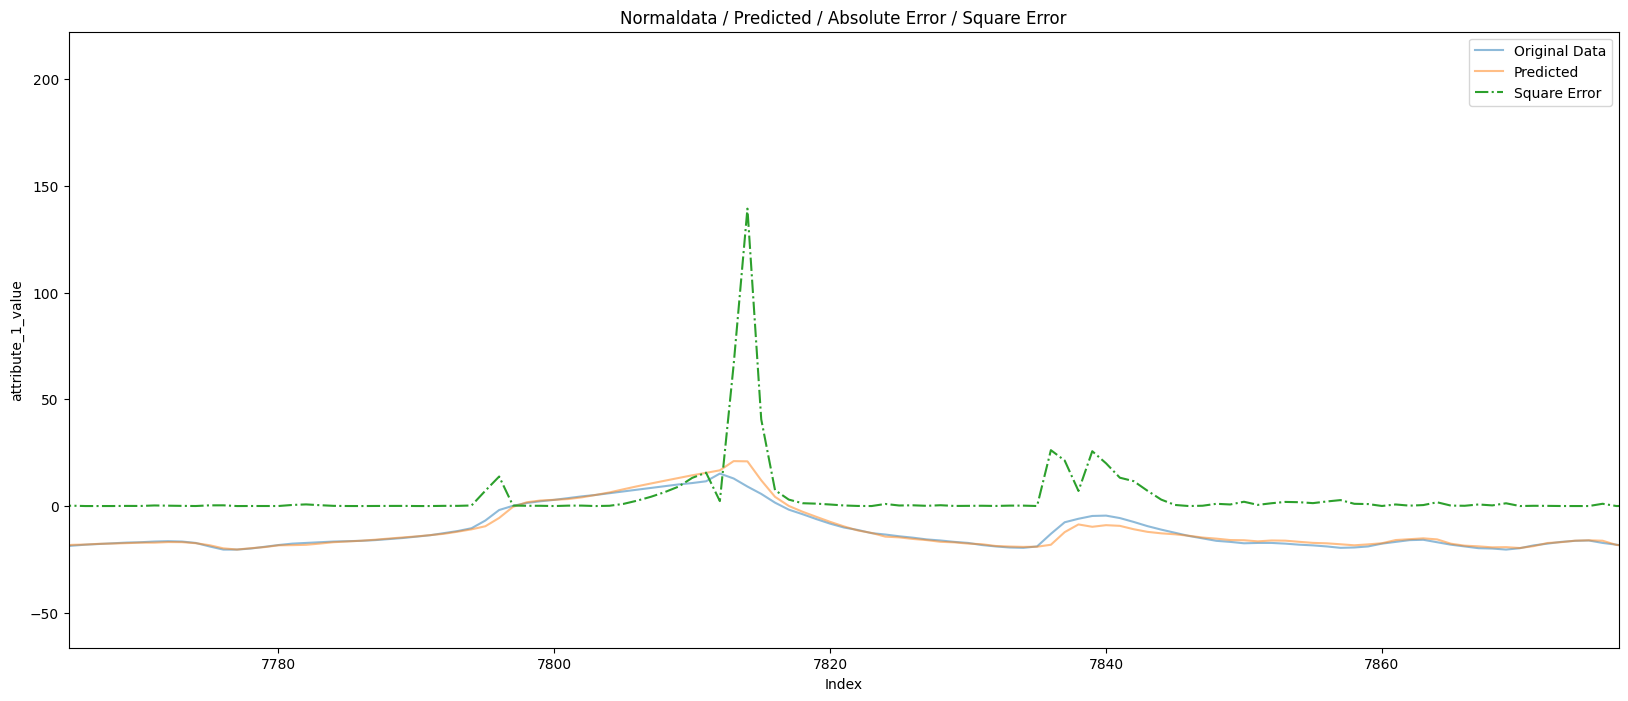

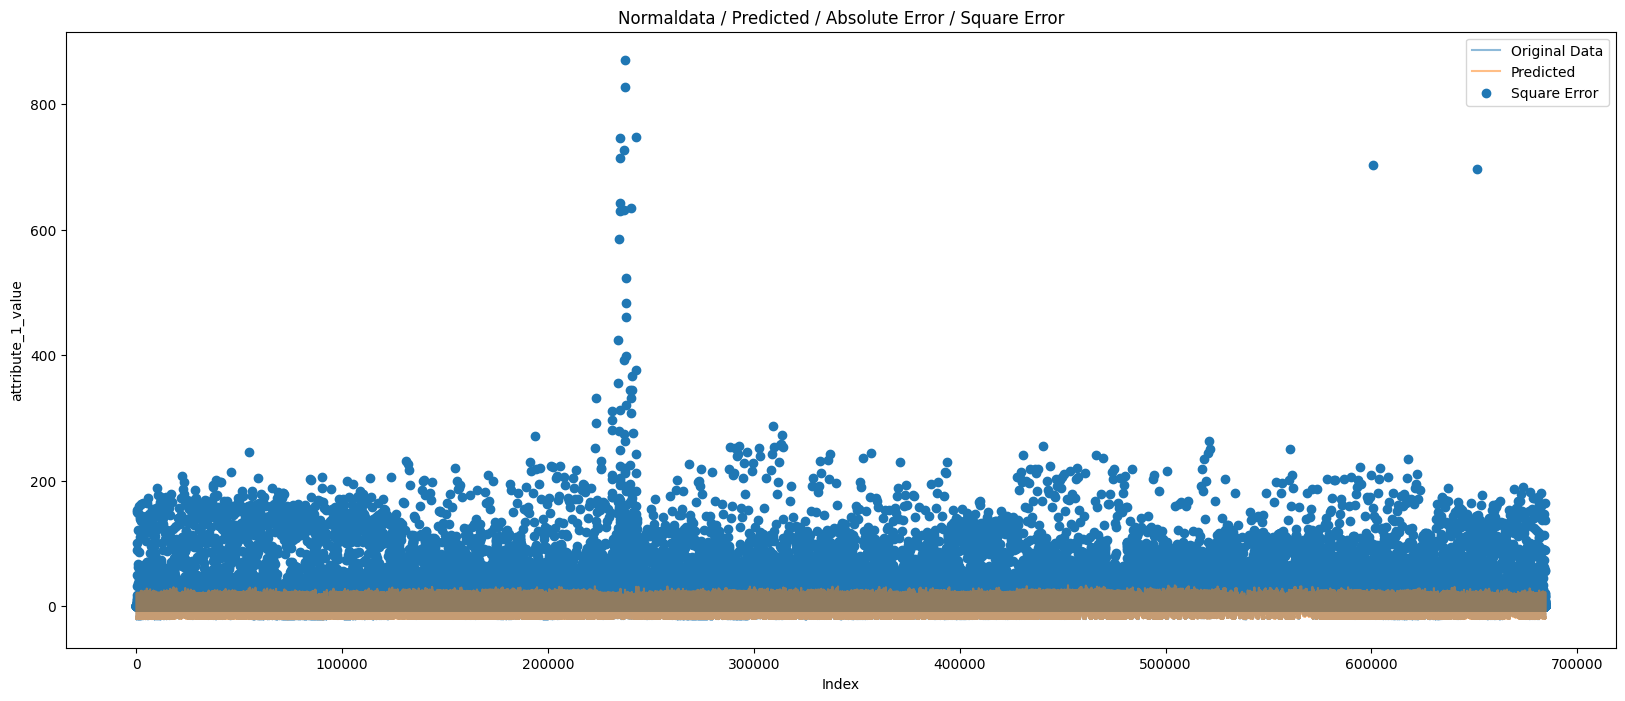

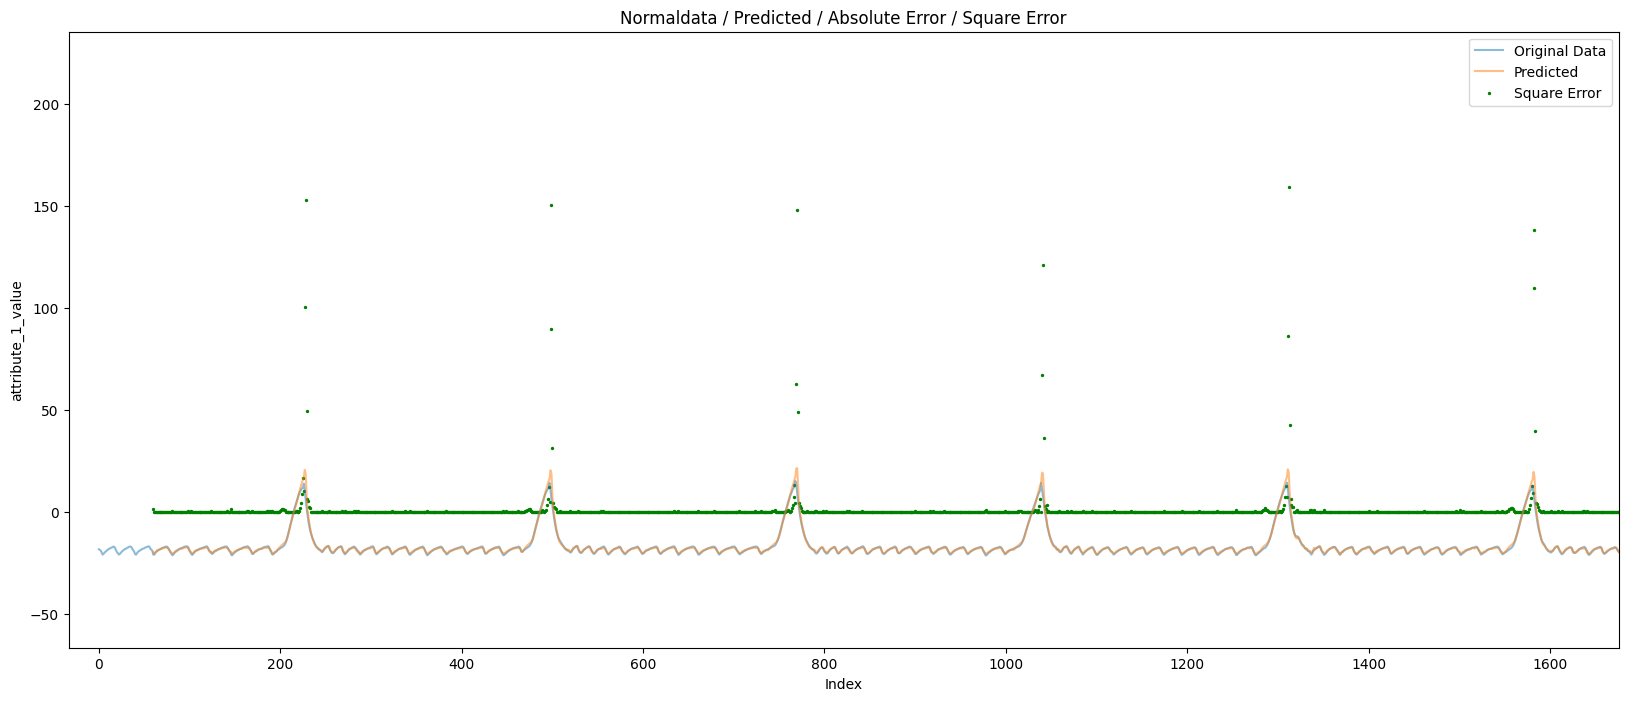

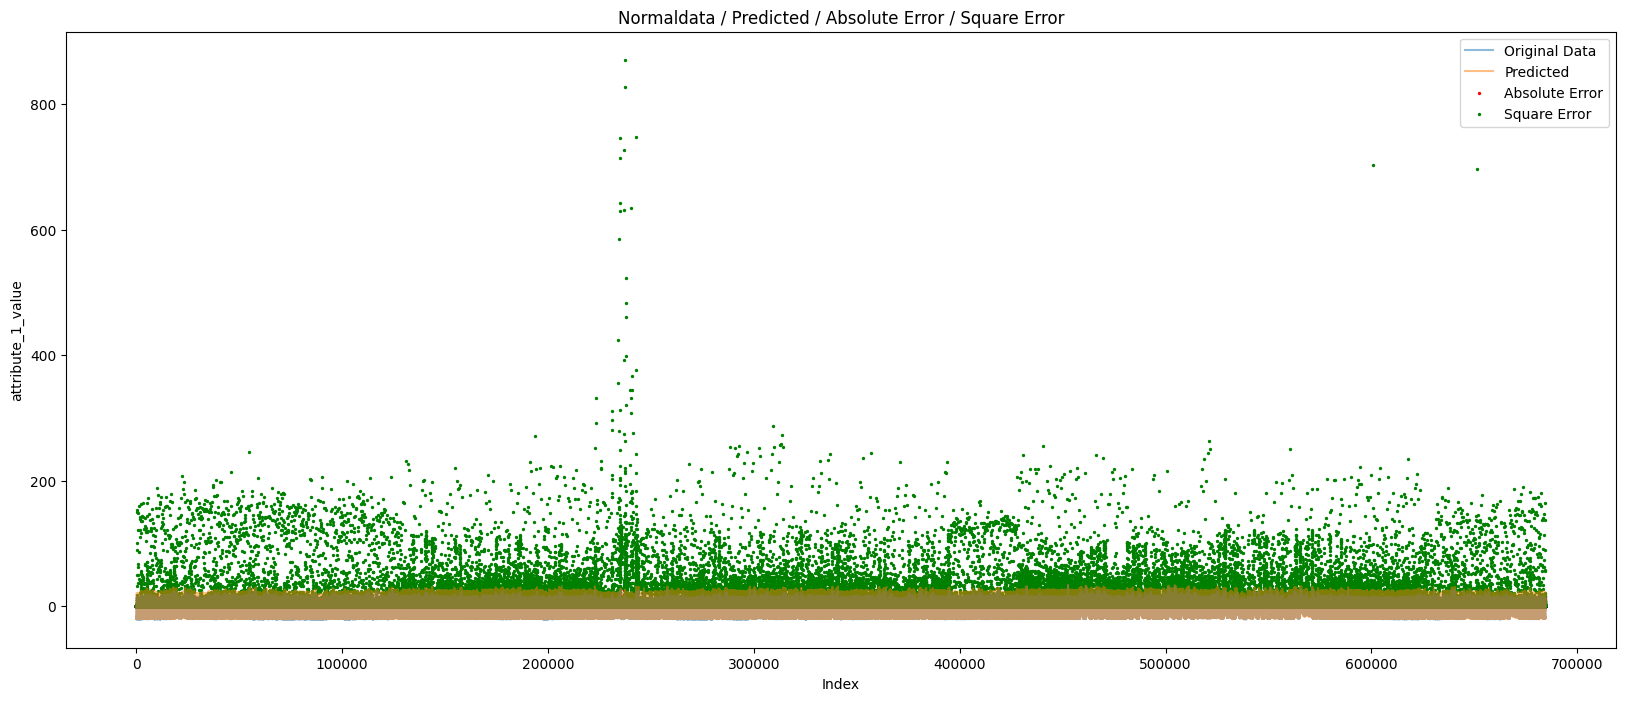

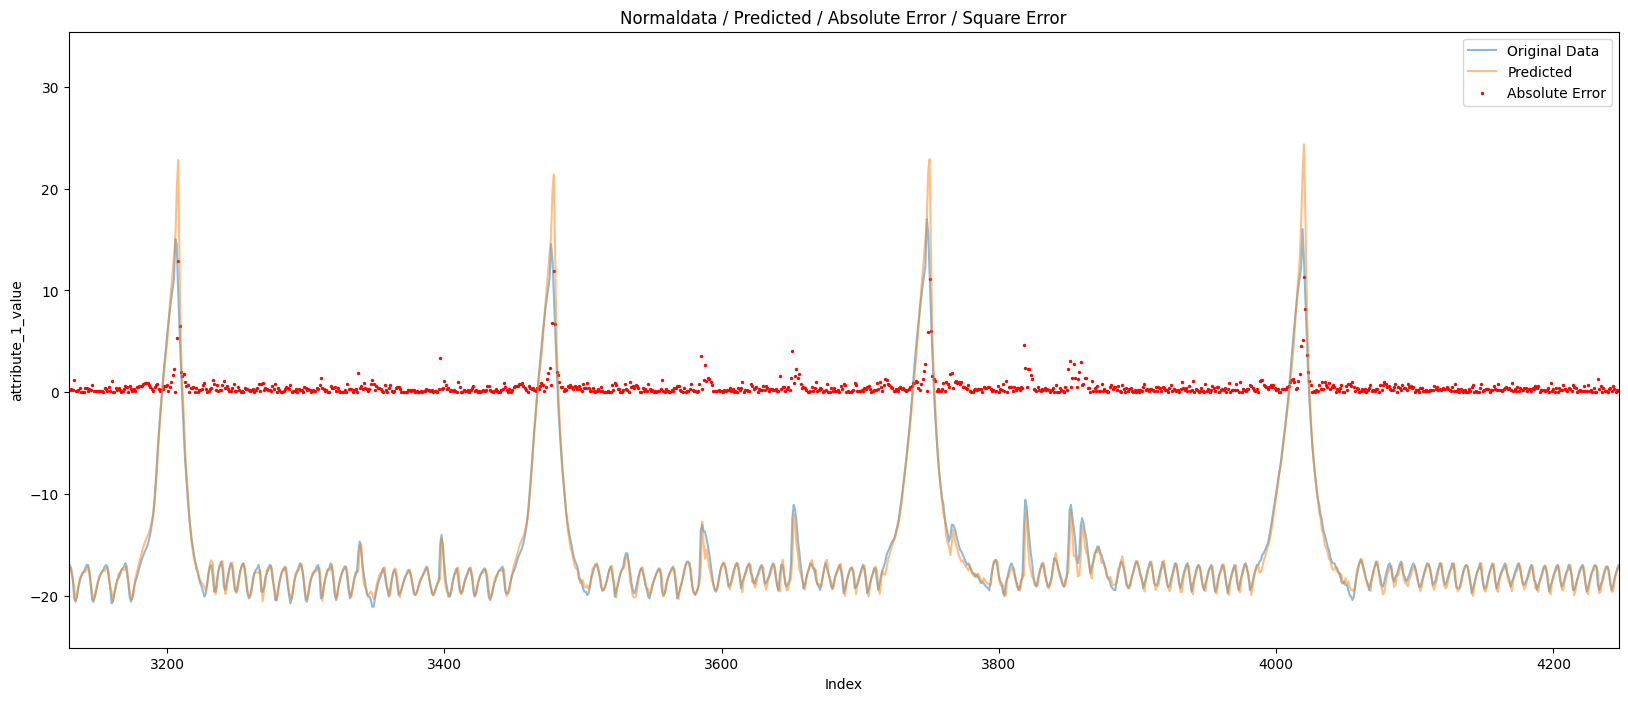

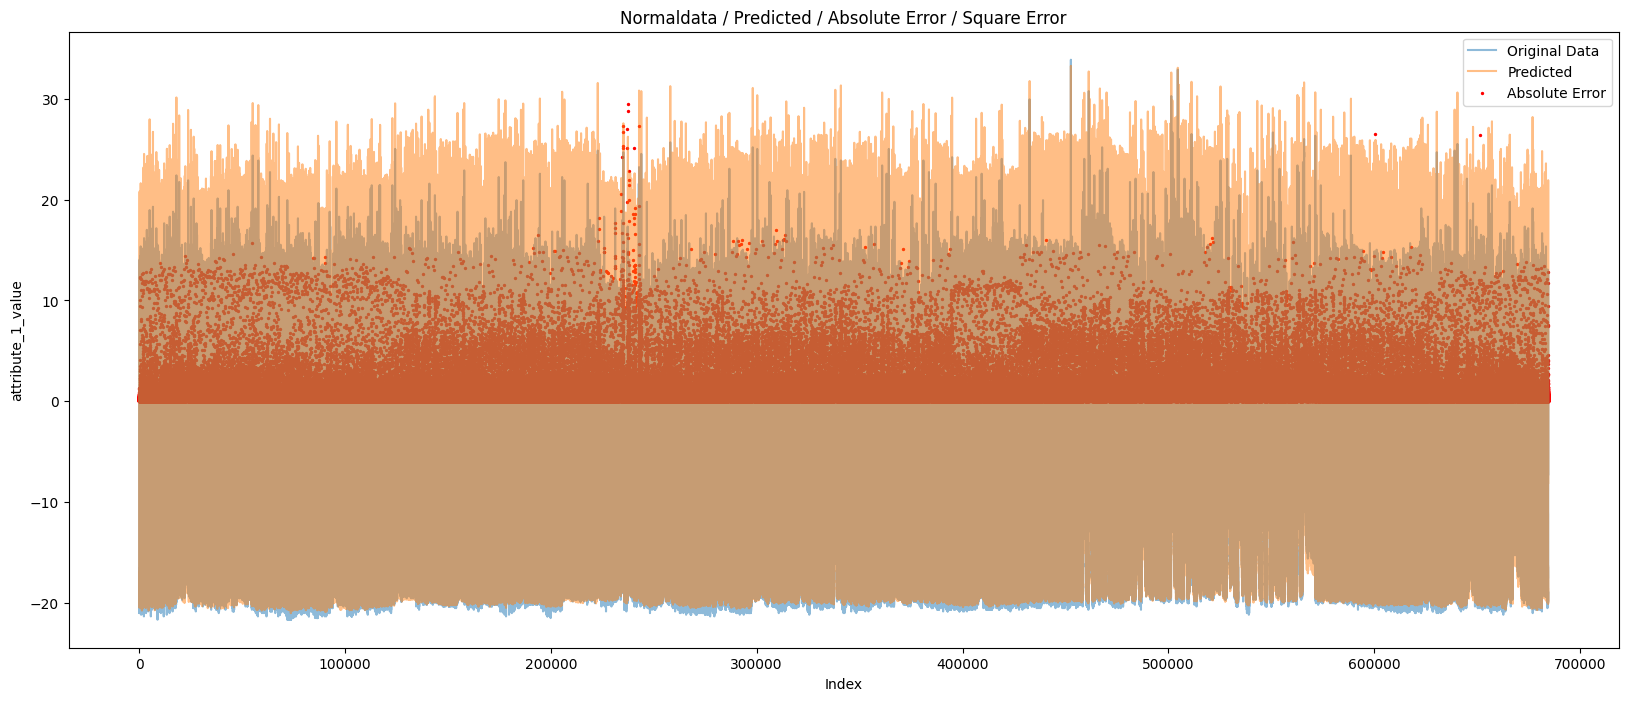

In [33]:
%matplotlib inline

plt.figure(figsize = (20,8))
plt.plot(np.arange(OriginalMAE.shape[0]), Original_X_scale_restored[:,0,0], label = 'Original Data', alpha = 0.5)
plt.plot(np.arange(OriginalMAE.shape[0]), original_predict_scale_restored[:-window_size], label = 'Predicted', alpha = 0.5)
# plt.plot(np.arange(OriginalMAE.shape[0]), OriginalMAE, label = 'Absolute Error', linestyle = '--', color = 'red')
# plt.plot(np.arange(OriginalMAE.shape[0]), OriginalMSE, label = 'Square Error', linestyle = '-.')
plt.scatter(np.arange(OriginalMAE.shape[0]), OriginalMAE, label = 'Absolute Error', s = 2, color = 'red')
# plt.scatter(np.arange(OriginalMAE.shape[0]), OriginalMSE, label = 'Square Error', s = 2, color = 'green')
plt.xlabel('Index')
plt.ylabel('attribute_1_value')
plt.title('Normaldata / Predicted / Absolute Error / Square Error')
plt.legend()
plt.show()

In [43]:
MAEMean = np.mean(OriginalMAE[~np.isnan(OriginalMAE)])
MAEStd = np.std(OriginalMAE[~np.isnan(OriginalMAE)])

MSEMean = np.mean(OriginalMSE[~np.isnan(OriginalMSE)])
MSEStd = np.std(OriginalMSE[~np.isnan(OriginalMSE)])

print(f'MAEMean : {MAEMean}')
print(f'MAEStd : {MAEStd}')
print(f'Mean + 3*std = {MAEMean + 3 * MAEStd}')
print(f'MSEMean : {MSEMean}')
print(f'MSEStd : {MSEStd}')


MAEMean : 0.6887399048485892
MAEStd : 0.7695624556038284
Mean + 3*std = 2.997427271660074
MSEMean : 1.0665890296058385
MSEStd : 5.250776201884035


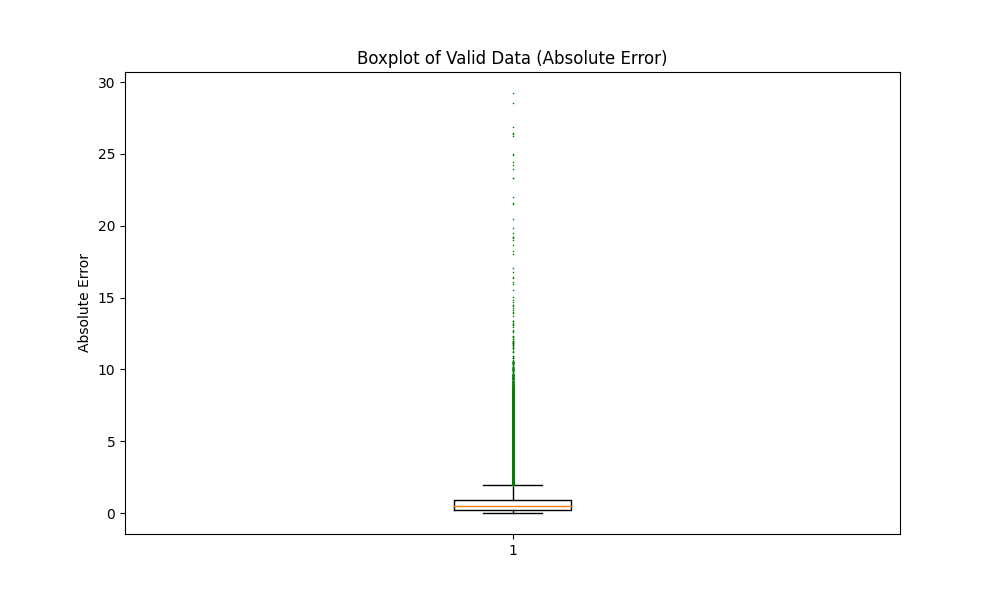

Q1: 0.22296932937253278
Q3: 0.9145813693514953

lower_bound : -0.8144487305959109
upper_bound : 1.951999429319939

Number of non-outlier points: 655288
Number of outlier points: 29234


In [37]:
# %matplotlib inline
valid_data = OriginalMAE[~np.isnan(OriginalMAE)]

plt.figure(figsize=(10,6))
plt.boxplot(valid_data, flierprops={'marker': 'x', 'markerfacecolor': 'green','markeredgecolor': 'green', 'markersize': 0.5})
plt.title('Boxplot of Valid Data (Absolute Error)')
plt.ylabel('Absolute Error')
plt.show()

Q1 = np.percentile(valid_data, 25)
Q3 = np.percentile(valid_data, 75)
IQR = Q3 - Q1

print(f"Q1: {Q1}")
print(f"Q3: {Q3}\n")

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"lower_bound : {lower_bound}")
print(f"upper_bound : {upper_bound}\n")

non_outliers = valid_data[(valid_data >= lower_bound) & (valid_data <= upper_bound)]
outliers = valid_data[(valid_data < lower_bound) | (valid_data > upper_bound)]

print("Number of non-outlier points:", len(non_outliers))
print("Number of outlier points:", len(outliers))

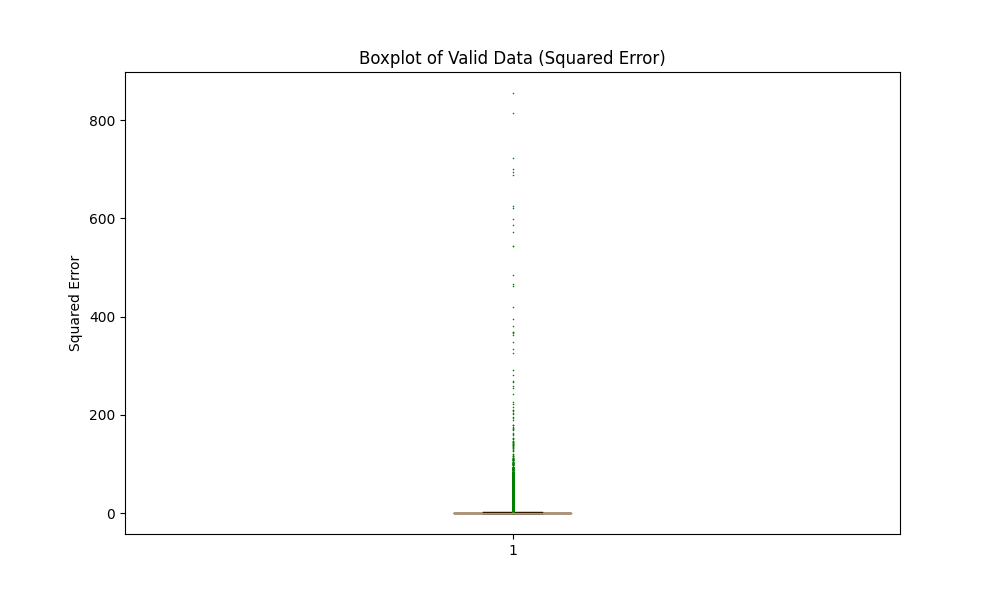

Q1: 0.04971532184111531
Q3: 0.8364590811661722

lower_bound : -1.13040031714647
upper_bound : 2.0165747201537574

Number of non-outlier points: 622227
Number of outlier points: 62295


In [38]:
valid_data = OriginalMSE[~np.isnan(OriginalMSE)]

plt.figure(figsize=(10,6))
plt.boxplot(valid_data, flierprops={'marker': 'x', 'markerfacecolor': 'green','markeredgecolor': 'green', 'markersize': 0.5})
plt.title('Boxplot of Valid Data (Squared Error)')
plt.ylabel('Squared Error')
plt.show()

Q1 = np.percentile(valid_data, 25)
Q3 = np.percentile(valid_data, 75)
IQR = Q3 - Q1

print(f"Q1: {Q1}")
print(f"Q3: {Q3}\n")

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"lower_bound : {lower_bound}")
print(f"upper_bound : {upper_bound}\n")

non_outliers = valid_data[(valid_data >= lower_bound) & (valid_data <= upper_bound)]
outliers = valid_data[(valid_data < lower_bound) | (valid_data > upper_bound)]

print("Number of non-outlier points:", len(non_outliers))
print("Number of outlier points:", len(outliers))

In [89]:
AbsoluteErrorArray = np.empty(OriginalMAE.shape)

for i in range(len(AbsoluteErrorArray)):
    if OriginalMAE[i] > 0.9145813693514953:
        AbsoluteErrorArray[i] = 1
AbsoluteErrorArray = np.array(AbsoluteErrorArray)
AbsoluteErrorArray = np.concatenate((np.full((30, ), np.nan), AbsoluteErrorArray), axis=0)

In [90]:
SquaredErrorArray = np.empty(OriginalMAE.shape)

for i in range(len(SquaredErrorArray)):
    if OriginalMAE[i] > 2.0165747201537574:
        SquaredErrorArray[i] = 1
SquaredErrorArray = np.array(SquaredErrorArray)
SquaredErrorArray = np.concatenate((np.full((30, ), np.nan), SquaredErrorArray), axis=0)

In [92]:
# data.shape #(684582, 5)
# TrailArray.shape #(684582,)
TrialData = data.copy()
TrialData['Absolute Error Classification'] = 0
TrialData['Squared Error Classification'] = 0

TrialData['Absolute Error Classification'] = AbsoluteErrorArray
TrialData['Squared Error Classification'] = SquaredErrorArray

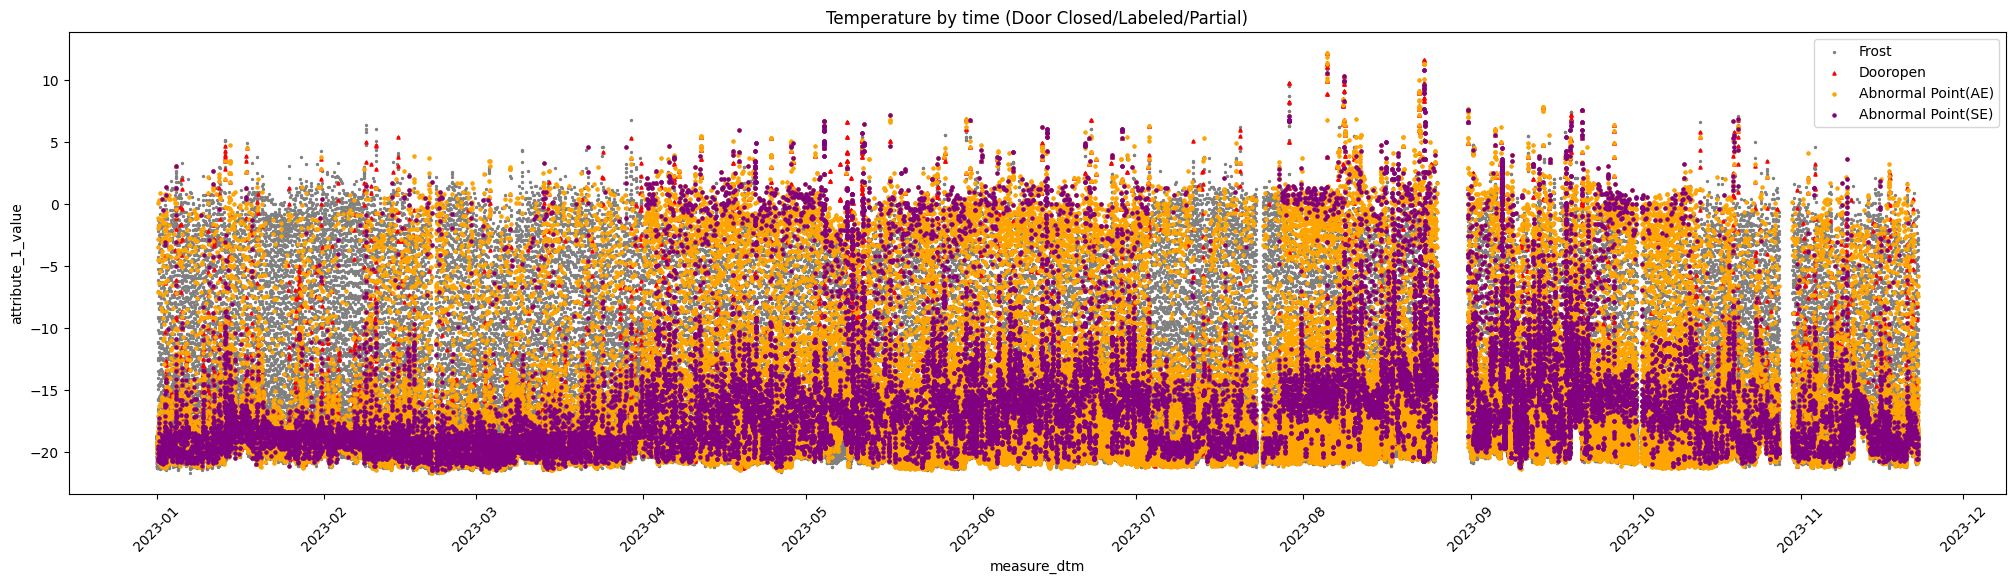

In [97]:
# TrialData

%matplotlib inline

# setLength = 3000
setLength = TrialData.shape[0]

plt.figure(figsize=(25, 6))
plt.title('Temperature by time (Door Closed/Labeled/Partial)')
plt.xlabel('measure_dtm')
plt.ylabel('attribute_1_value')
plt.xticks(rotation=45)

plt.scatter(TrialData.iloc[:setLength, 1], TrialData.iloc[:setLength, 2], s=2, color='grey')


doorOpenCondition = TrialData.iloc[:setLength, 4] == 1
plt.scatter(TrialData.iloc[:setLength, 1][doorOpenCondition], TrialData.iloc[:setLength, 2][doorOpenCondition], color='red', marker='^', s=5)

absoluteErrorPoint = TrialData.iloc[:setLength, 5] == 1
plt.scatter(TrialData.iloc[:setLength, 1][absoluteErrorPoint], TrialData.iloc[:setLength, 2][absoluteErrorPoint], color='orange', marker='o', s=5)

squaredErrorPoint = TrialData.iloc[:setLength, 6] == 1
plt.scatter(TrialData.iloc[:setLength, 1][squaredErrorPoint], TrialData.iloc[:setLength, 2][squaredErrorPoint], color='purple', marker='o', s=5)

plt.legend(['Frost', 'Dooropen', 'Abnormal Point(AE)', 'Abnormal Point(SE)'])

plt.show()

### 1D-CNN

Epoch 1/500
1781/1781 [==============================] - 9s 5ms/step - loss: 0.1828 - mse: 0.1828 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 2/500
1781/1781 [==============================] - 8s 4ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 3/500
1781/1781 [==============================] - 8s 4ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 4/500
1781/1781 [==============================] - 8s 4ms/step - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 5/500
1781/1781 [==============================] - 8s 4ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 6/500
1781/1781 [==============================] - 8s 4ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/500
1781/1781 [==============================] - 7s 4ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 8/500
1781/1781 [==============================] 

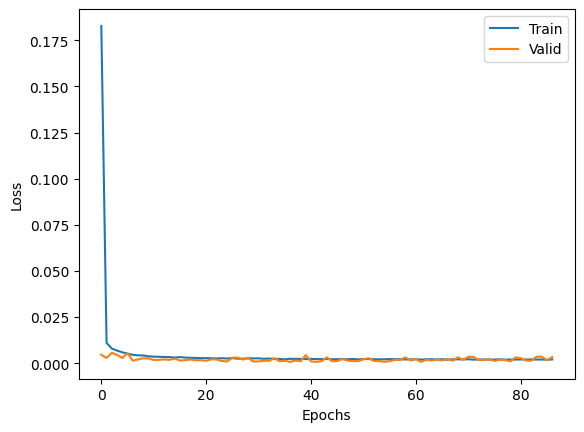

In [33]:
seed_value = 42
np.random.seed(seed_value)       
random.seed(seed_value)          
tf.random.set_seed(seed_value)

def model1DCNN(window_size, numberOfFeatures):
    model = Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(window_size, numberOfFeatures)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    
    model.add(keras.layers.Conv1D(filters=128, kernel_size=3, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Conv1D(filters=128, kernel_size=3, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))

    model.add(keras.layers.Flatten())
    model.add(Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.5))
    
    model.add(Dense(1, activation='linear'))  
    return model

window_size = 30
numberOfFeatures = 2
modelCNN = model1DCNN(window_size, numberOfFeatures)

modelCNN.compile(optimizer='adam', loss='mse', metrics=['mse'])
earlyStopping = EarlyStopping( monitor='val_loss', patience=50, verbose=1, restore_best_weights=True)
history = modelCNN.fit(train_X, train_Y, epochs=500, batch_size=8, validation_data=(valid_X, valid_Y), callbacks=[earlyStopping])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()


In [10]:
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 64)            448       
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 64)            0         
                                                                 
 flatten (Flatten)           (None, 832)               0         
                                                                 
 dense (Dense)               (None, 100)               83300     
                                                        

In [34]:
modelCNN.save('model1DCNNver4.h5')

In [39]:
TrainedmodelCNN = keras.models.load_model('model1DCNNver4.h5')

In [40]:
TrainedmodelCNN.evaluate(test_X, test_Y)

273/273 [==============================] - 1s 2ms/step - loss: 8.6979e-04 - mse: 8.6979e-04


[0.0008697898010723293, 0.0008697898010723293]

In [16]:
def predict(model, data, idx, batch_size = 256):
    num_samples = min(idx, len(data))
    result = []

    # 배치 처리를 통한 모델 예측
    batch_indices = np.arange(0, num_samples, batch_size)
    for start_idx in batch_indices:
        end_idx = min(start_idx + batch_size, num_samples)
        batch_data = np.array([data[i].reshape(1, data[i].shape[0], numberOfFeatures) for i in range(start_idx, end_idx)])
        batch_data = np.vstack(batch_data) 
        batch_predictions = model.predict(batch_data)
        result.extend(batch_predictions.flatten())

    result = np.array(result).reshape(-1, 1)

    nan_array = np.full((30, 1), np.nan) 
    result = np.concatenate((nan_array, result), axis=0)

    return result

In [41]:
test_X_scale_restored = test_X.copy()
test_X_scale_restored[:,0,0] = test_X[:,0,0] * (temp_max - temp_min) + temp_min

test_X_predict = predict(TrainedmodelCNN, test_X_scale_restored, test_X.shape[0])

test_X_predict_scale_restored = test_X_predict * (temp_max - temp_min) + temp_min

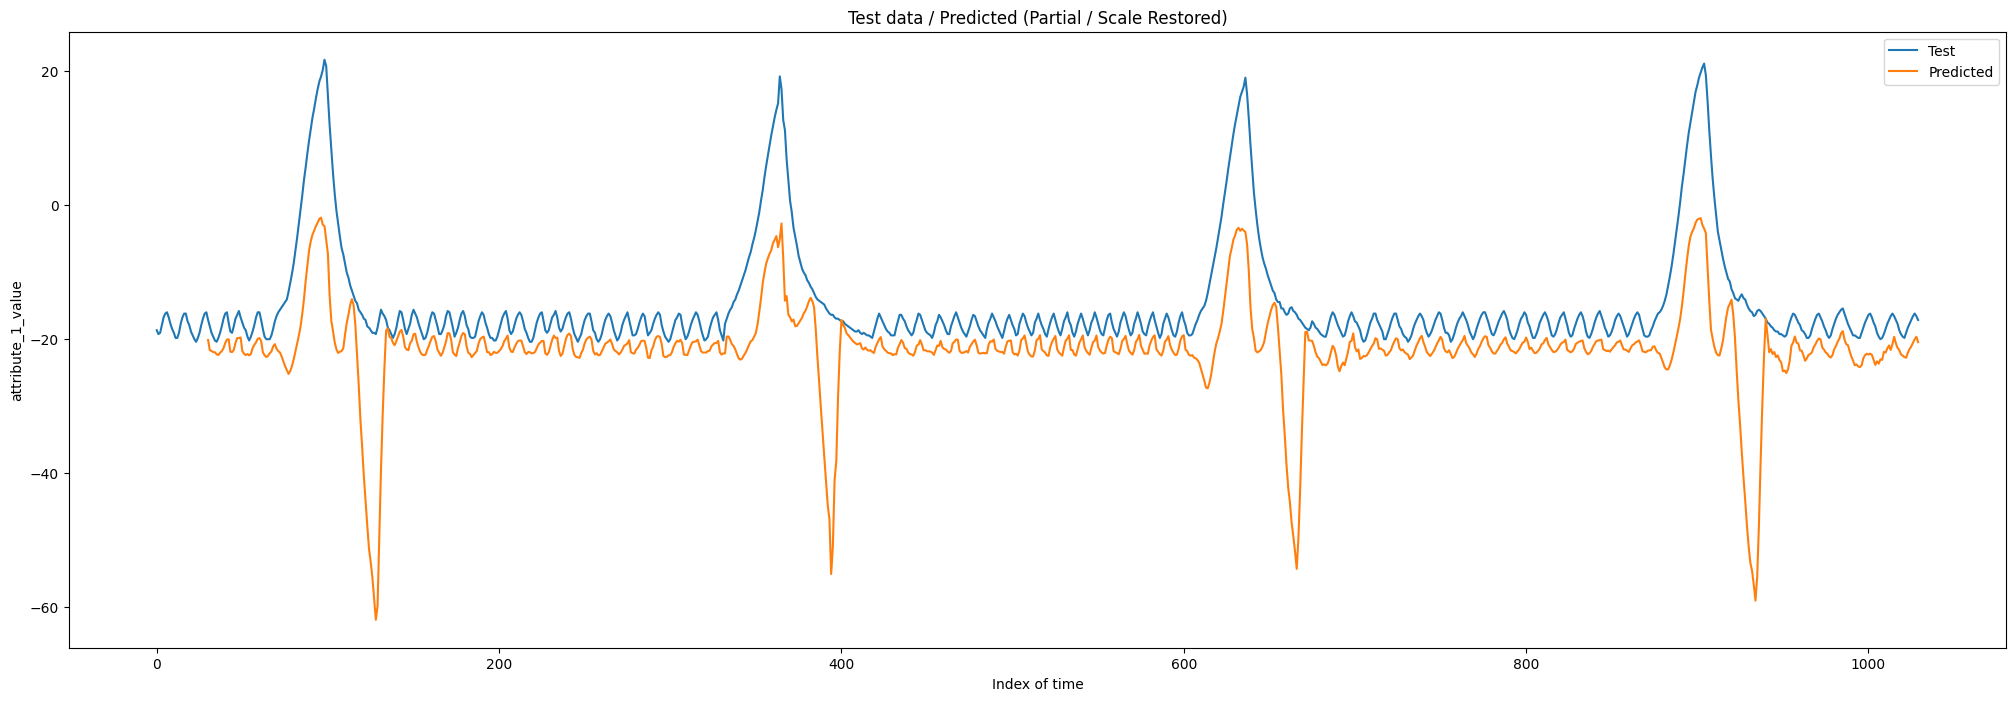

In [42]:
%matplotlib inline
whereToSlice = 1030
plt.figure(figsize = (25,8))
plt.plot(np.arange(whereToSlice), test_X_scale_restored[:whereToSlice,0,0])
plt.plot(np.arange(whereToSlice), test_X_predict_scale_restored[:whereToSlice])
plt.title('Test data / Predicted (Partial / Scale Restored)')
plt.xlabel('Index of time')
plt.ylabel('attribute_1_value')
plt.legend(['Test', 'Predicted'])
plt.show()

# 종합 계산

In [43]:
def reconstructionError(data, model, min_data, max_data, batch_size=128):
    num_samples = data.shape[0]
    mse_result = []
    mae_result = []

    predictions = model.predict(data.reshape(num_samples, 30, 2), batch_size=batch_size)
    
    data_rescaled = data[:, :, 0] * (max_data - min_data) + min_data
    predictions_rescaled = predictions[:, :, 0] * (max_data - min_data) + min_data
    
    mse_errors = np.mean(np.square(data_rescaled - predictions_rescaled), axis=1)
    mae_errors = np.mean(np.abs(data_rescaled - predictions_rescaled), axis=1)

    mse_result.extend(mse_errors.tolist())
    mae_result.extend(mae_errors.tolist())

    return mse_result, mae_result


In [44]:
trainErrors_mse, trainErrors_mae = reconstructionError(train_X, trainedLSTMAEModel, temp_min, temp_max)
OriginalErrors_mse, OriginalErrors_mae = reconstructionError(Original_X, trainedLSTMAEModel, min_data, max_data)
doorErrors_mse, doorErrors_mae = reconstructionError(Opened_X, trainedLSTMAEModel, min_door, max_door)

NameError: name 'trainedLSTMAEModel' is not defined

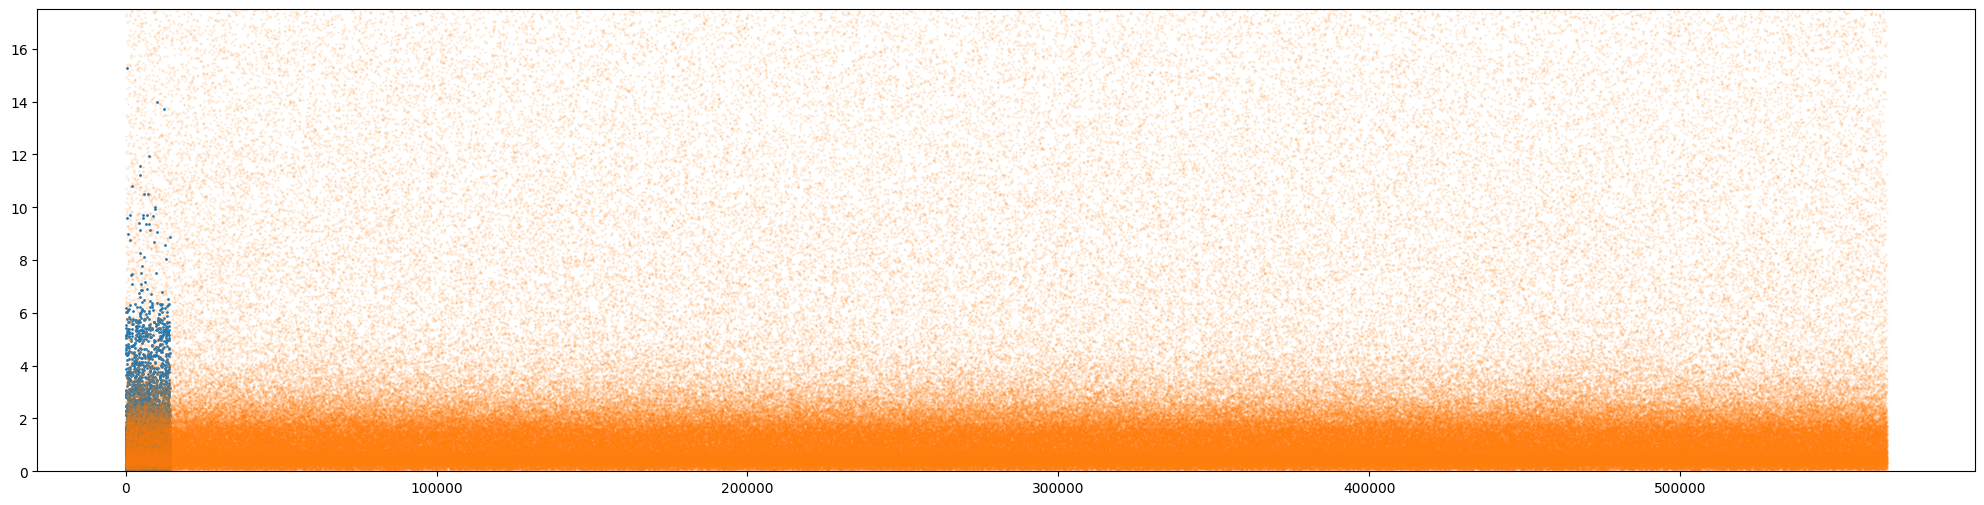

In [136]:
plt.figure(figsize=(25, 6))
plt.scatter(np.arange(len(trainErrors_mse)),trainErrors_mse, s = 1) 
# plt.scatter(np.arange(len(OriginalErrors_mse)),OriginalErrors_mse, s = 1)
plt.scatter(np.arange(len(doorErrors_mse)),doorErrors_mse, s = 1, alpha=0.1)
plt.ylim(0,17.5)
plt.show() 

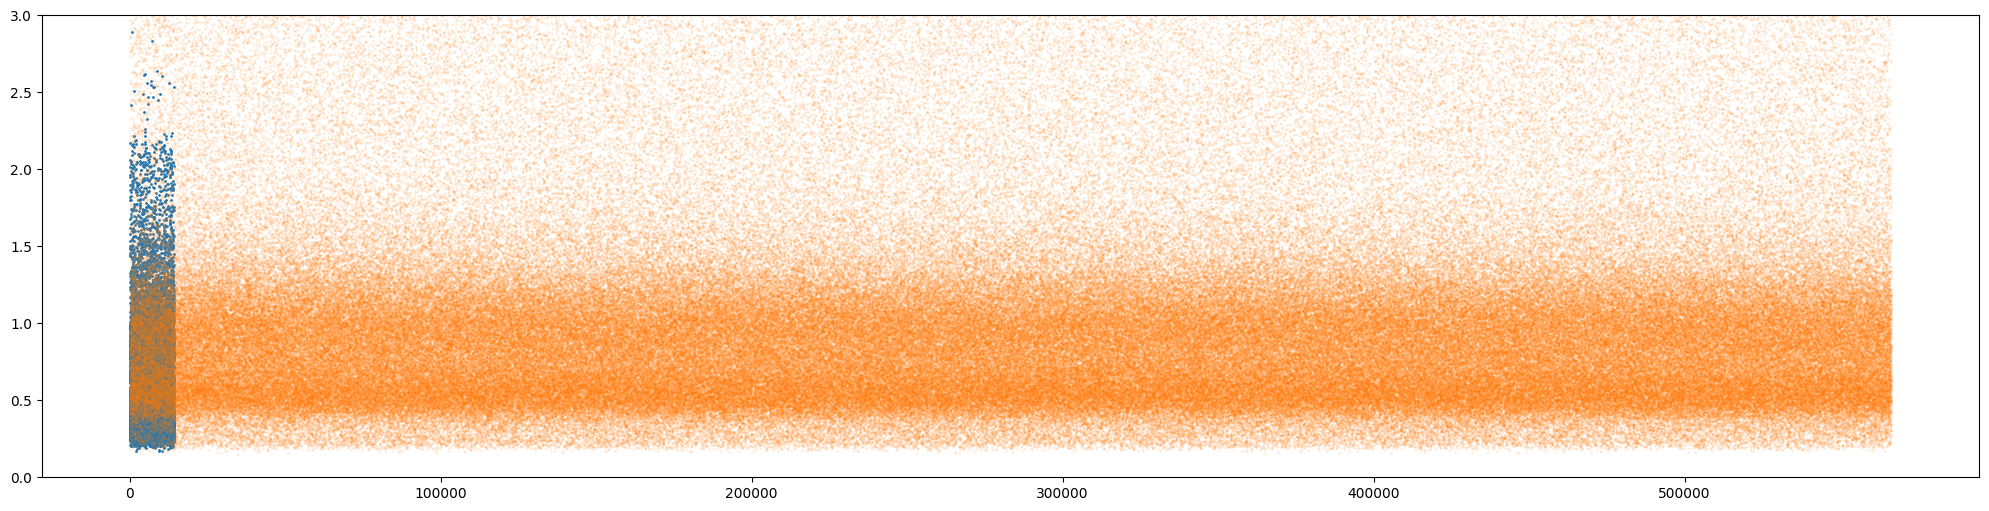

In [139]:
plt.figure(figsize=(25, 6))
plt.scatter(np.arange(len(trainErrors_mae)),trainErrors_mae, s = 1) 
plt.scatter(np.arange(len(doorErrors_mae)),doorErrors_mae, s = 1, alpha=0.1)
plt.ylim(0,3)
plt.show() 

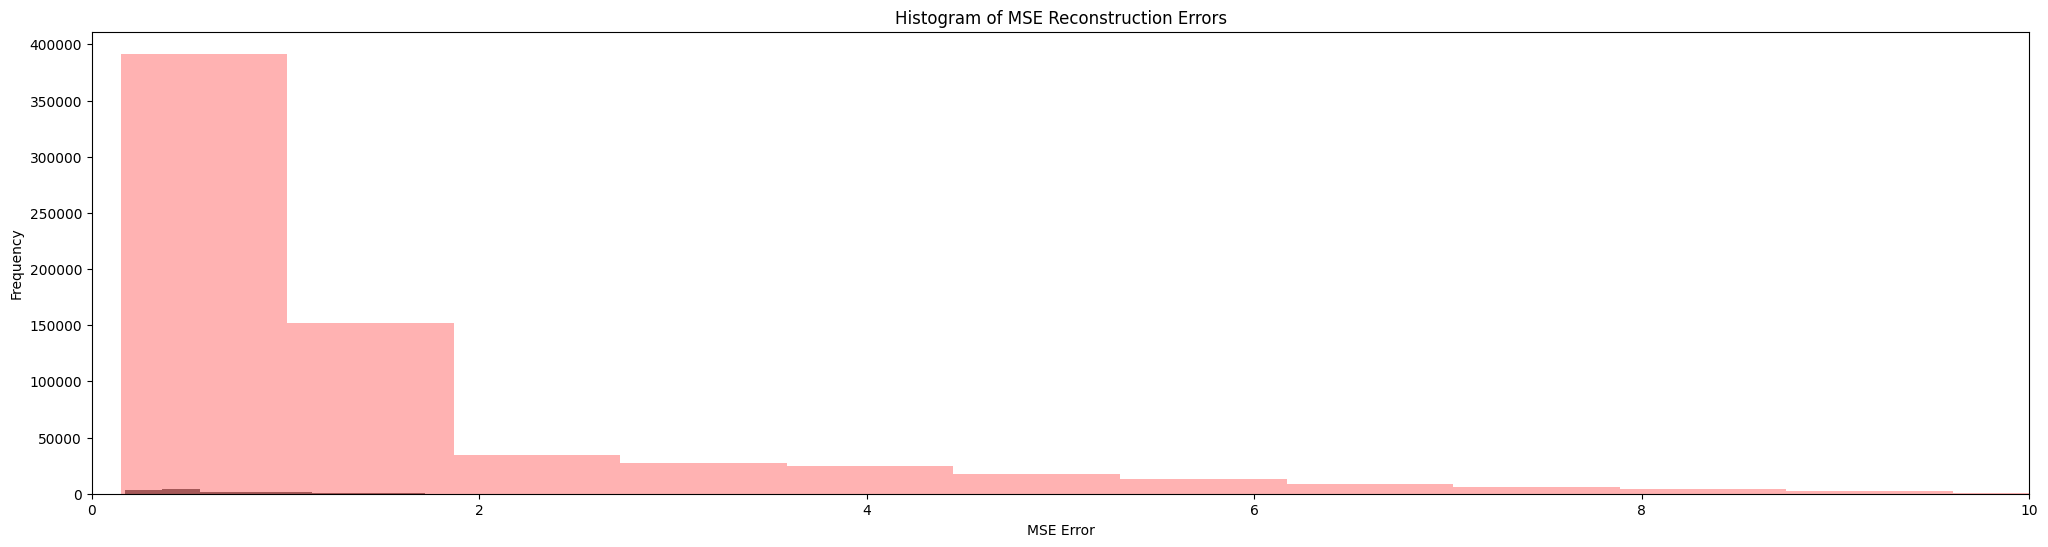

In [85]:
plt.figure(figsize=(25, 6))
plt.hist(trainErrors_mae, bins=20, color='black', alpha=0.5)
# plt.hist(OriginalErrors_mse, bins=5, color='orange', alpha=0.7)
plt.hist(OriginalErrors_mae, bins=30, color='red', alpha=0.3)
plt.title('Histogram of MSE Reconstruction Errors')
plt.xlim(0,10)
plt.xlabel('MSE Error')
plt.ylabel('Frequency')
plt.show()


In [168]:
train_mean_mse = np.mean(trainErrors_mse)
train_std_mse = np.std(trainErrors_mse)

Original_mean_mse = np.mean(OriginalErrors_mse)
Original_std_mse = np.std(OriginalErrors_mse)

door_mean_mse = np.mean(doorErrors_mse)
door_std_mse = np.std(doorErrors_mse)

print(f'train_MSE : {train_mean_mse}, {train_std_mse}')
print(f'Original_MSE : {Original_mean_mse}, {Original_std_mse}')
print(f'door_MSE : {door_mean_mse}, {door_std_mse}')

train_mean_mae = np.mean(trainErrors_mae)
train_std_mae = np.std(trainErrors_mae)

Original_mean_mae = np.mean(OriginalErrors_mae)
Original_std_mae = np.std(OriginalErrors_mae)

door_mean_mae = np.mean(doorErrors_mae)
door_std_mae = np.std(doorErrors_mae)

print(f'train_MAE : {train_mean_mae}, {train_std_mae}')
print(f'Original_MAE : {Original_mean_mae}, {Original_std_mae}')
print(f'door_MAE : {door_mean_mae}, {door_std_mae}')

train_MSE : 1.8926619954227342, 2.585067944903076
Original_MSE : 7.323537528632002, 20.810684174822786
door_MSE : 2.641038769594734, 7.2455440540983185
train_MAE : 1.0159422381194192, 0.4858819769968014
Original_MAE : 1.554798569675845, 1.7053063719719737
door_MAE : 1.0868934093732319, 0.7290810020743913


# 이상 시각화